# Práctica 2. Clustering de semillas

## 1. Visualización de datos con distintos scalers + PCA

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


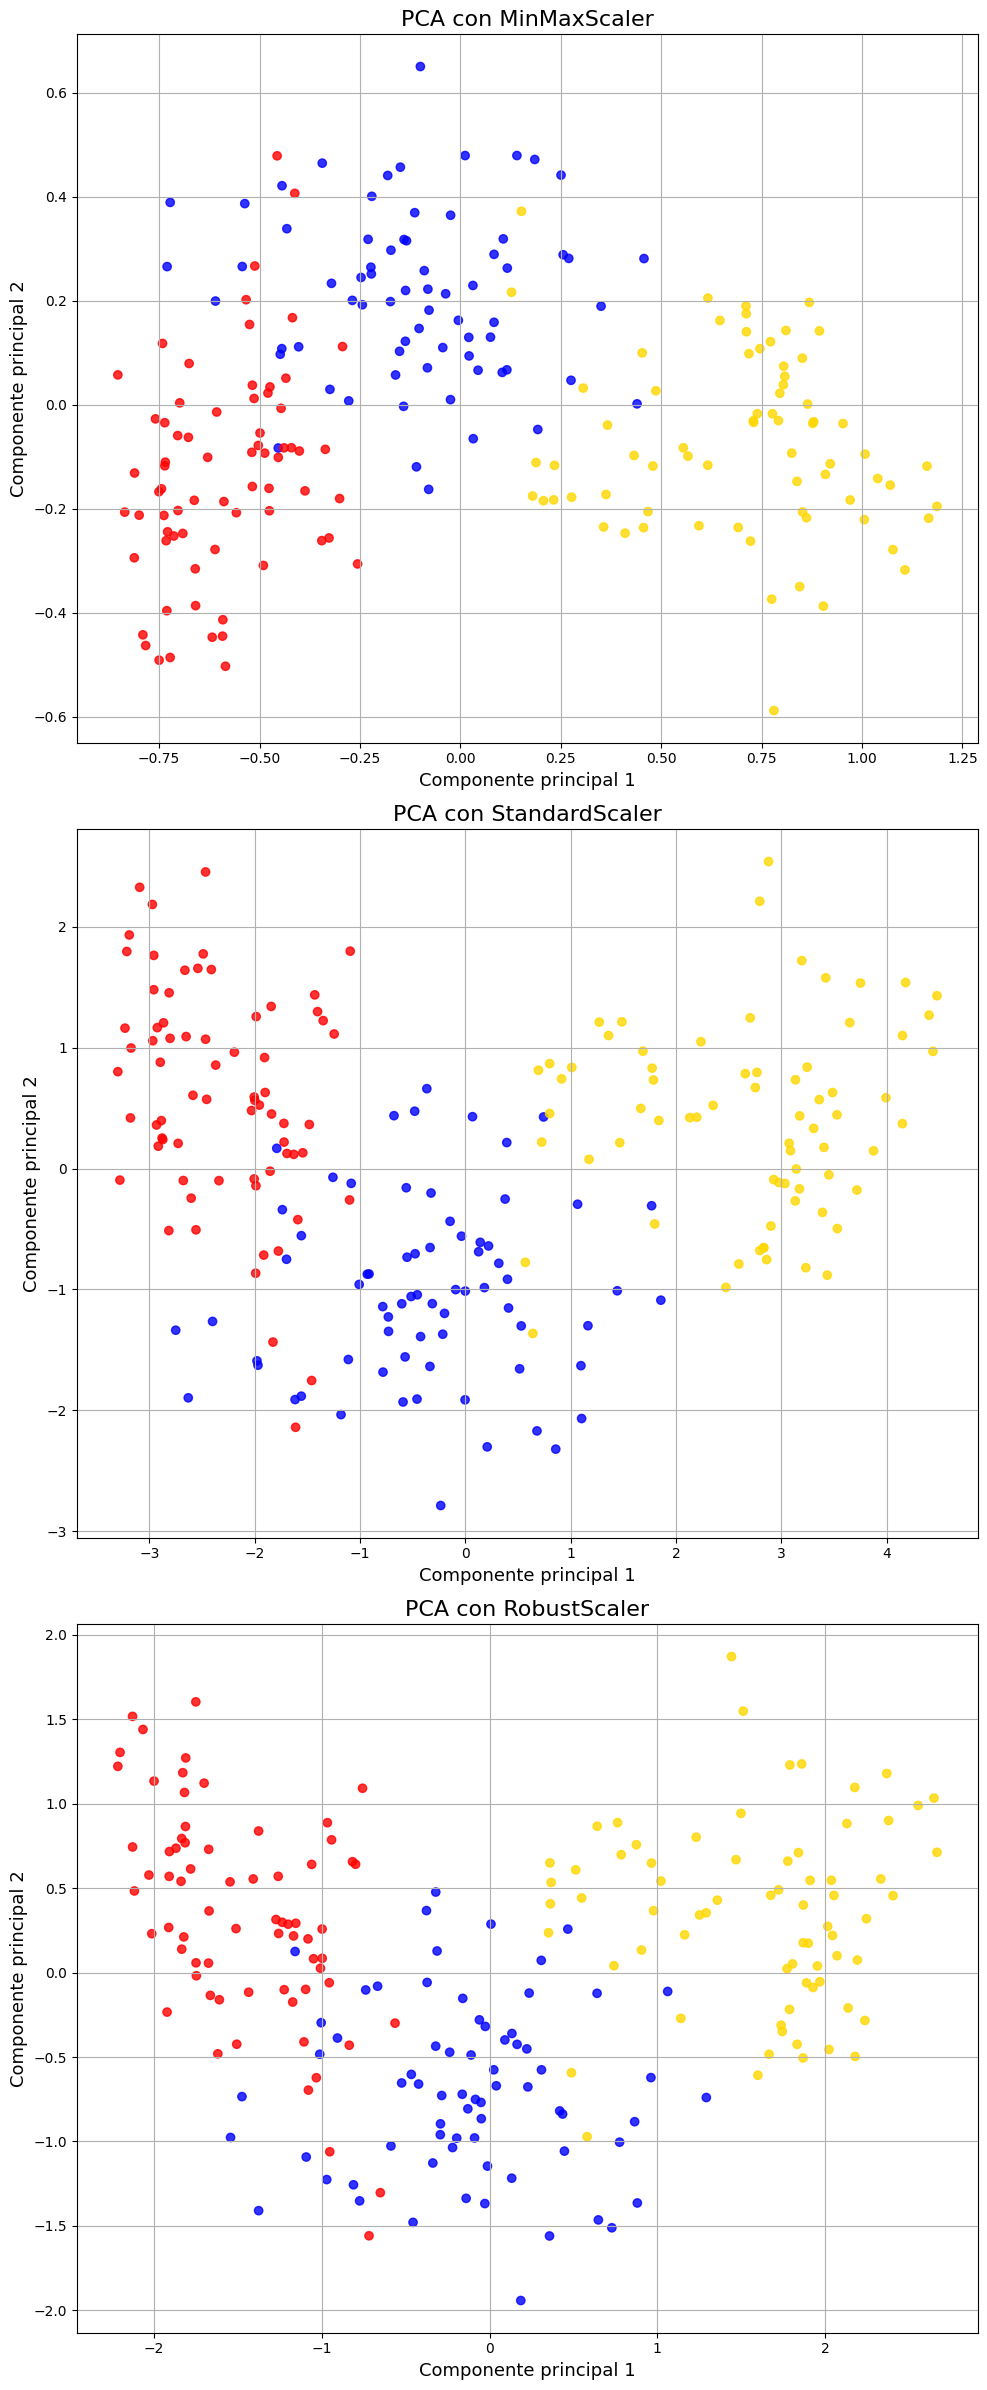

In [27]:
# Cargar datos
df = pd.read_csv("semillas.csv")
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Mapeo de colores personalizados por clase
color_map = {1: 'blue', 2: 'gold', 3: 'red'}
colors = y.map(color_map)

# Definir los escaladores
scalers = {
    "MinMaxScaler": MinMaxScaler(),
    "StandardScaler": StandardScaler(),
    "RobustScaler": RobustScaler()
}

# Crear figura para mostrar los 3 gráficos verticalmente
fig, axes = plt.subplots(3, 1, figsize=(10, 24))  # 10 de ancho, 24 de alto

for ax, (scaler_name, scaler) in zip(axes, scalers.items()):
    pipeline = Pipeline([
        ("scaler", scaler),
        ("pca", PCA(n_components=2))
    ])
    X_pca = pipeline.fit_transform(X)

    ax.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, alpha=0.8)
    ax.set_title(f"PCA con {scaler_name}", fontsize=16)
    ax.set_xlabel("Componente principal 1", fontsize=13)
    ax.set_ylabel("Componente principal 2", fontsize=13)
    ax.grid(True)

plt.tight_layout()
plt.show()

### Comparativa de escaladores tras PCA 

Se ha aplicado PCA a los datos de semillas tras escalar con tres métodos distintos: **MinMaxScaler**, **StandardScaler** y **RobustScaler**. En cada caso se proyectan las instancias sobre los dos primeros componentes principales.

Los puntos están coloreados según la clase real de semilla:
- 🔵 Clase 1
- 🟡 Clase 2
- 🔴 Clase 3

#### Observaciones:
- **MinMaxScaler** ofrece una separación aceptable, especialmente entre las clases 2 (amarillo) y 3 (rojo), aunque con algo más de solapamiento en el centro.
- **StandardScaler** proporciona una separación **muy clara entre las tres clases**, con fronteras bastante definidas entre cada grupo. Las clases se distribuyen mejor en el plano de componentes.
- **RobustScaler** también consigue una separación razonable, aunque los grupos no se distinguen tanto como con StandardScaler. Aun así, es robusto ante valores extremos.

#### Conclusión:
**StandardScaler** es el método de escalado que mejor preserva la estructura de clases del conjunto de datos original, facilitando una posible tarea de clustering. Por ello, se utilizará como preprocesamiento base en los siguientes apartados.


## 2. Técnicas de Clustering
Usamos X_2d aplicar los algoritmos de clustering: KMeans, jerárquico y DBSCAN, y visualizar los resultados de los clusters en un gráfico bidimensional

In [28]:
# Separar características (sin la clase)
X = df.iloc[:, :-1]

# Aplicar escalado y reducción a 2 dimensiones
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

### Método del codo y silhoutte (KMeans)

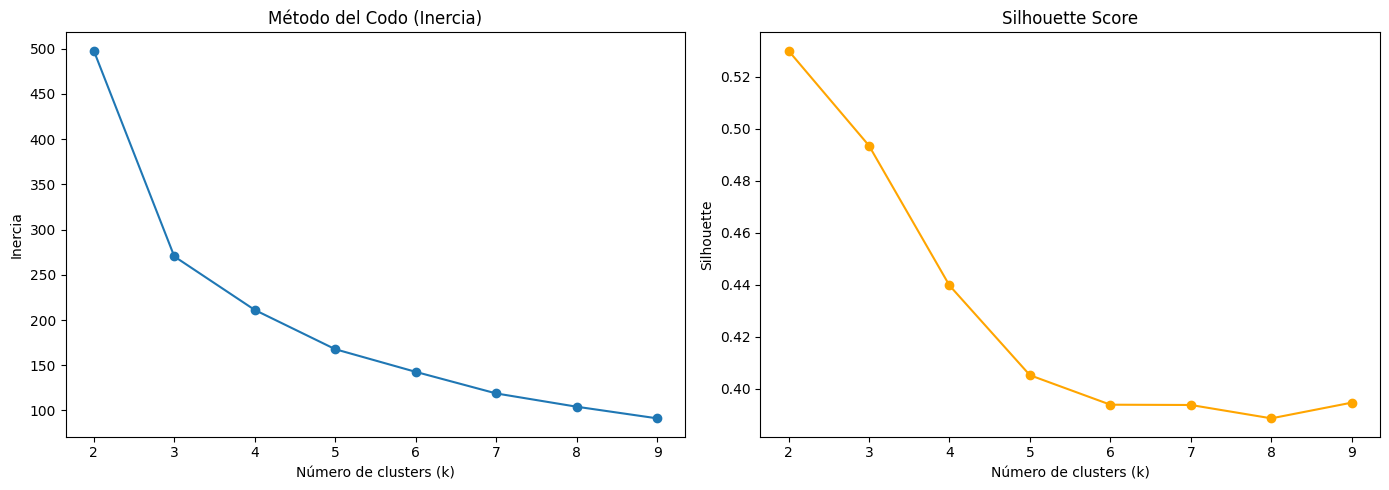

In [29]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertia = []
silhouette = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init=25, random_state=42)
    kmeans.fit(X_2d)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_2d, kmeans.labels_))

# Gráficos de evaluación
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Elbow
ax[0].plot(K_range, inertia, marker='o')
ax[0].set_title("Método del Codo (Inercia)")
ax[0].set_xlabel("Número de clusters (k)")
ax[0].set_ylabel("Inercia")

# Silhouette
ax[1].plot(K_range, silhouette, marker='o', color='orange')
ax[1].set_title("Silhouette Score")
ax[1].set_xlabel("Número de clusters (k)")
ax[1].set_ylabel("Silhouette")

plt.tight_layout()
plt.show()

- **Método del Codo**: La inercia decrece al aumentar k, pero el cambio más significativo parece estar en k = 3, lo cual sugiere que podría ser un buen número de clusters.

-  **Silhouette Score**: El valor también es más alto para k = 3, lo que confirma que 3 es una buena elección, ya que indica mejor separación entre clusters.

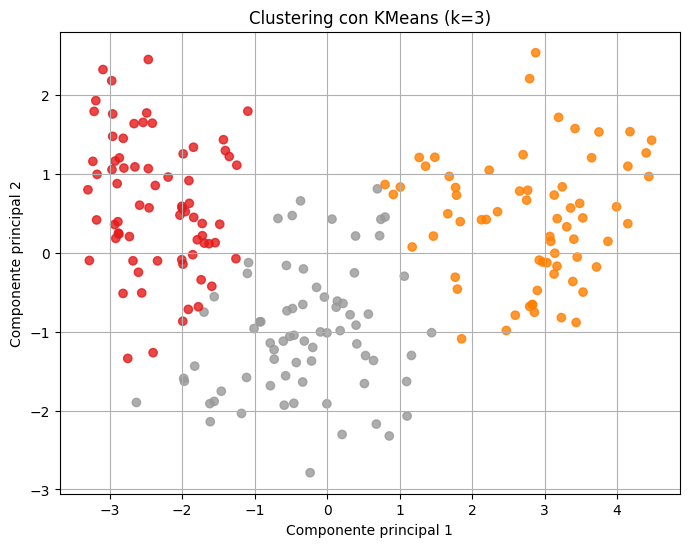

In [30]:
# Aplicar KMeans con k=3
kmeans_final = KMeans(n_clusters=3, n_init=25, random_state=42)
labels_kmeans = kmeans_final.fit_predict(X_2d)

# Visualizar los clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_kmeans, cmap="Set1", alpha=0.8)
plt.title("Clustering con KMeans (k=3)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.grid(True)
plt.show()

## Método Hierarchical Clustering / Dendrogramas

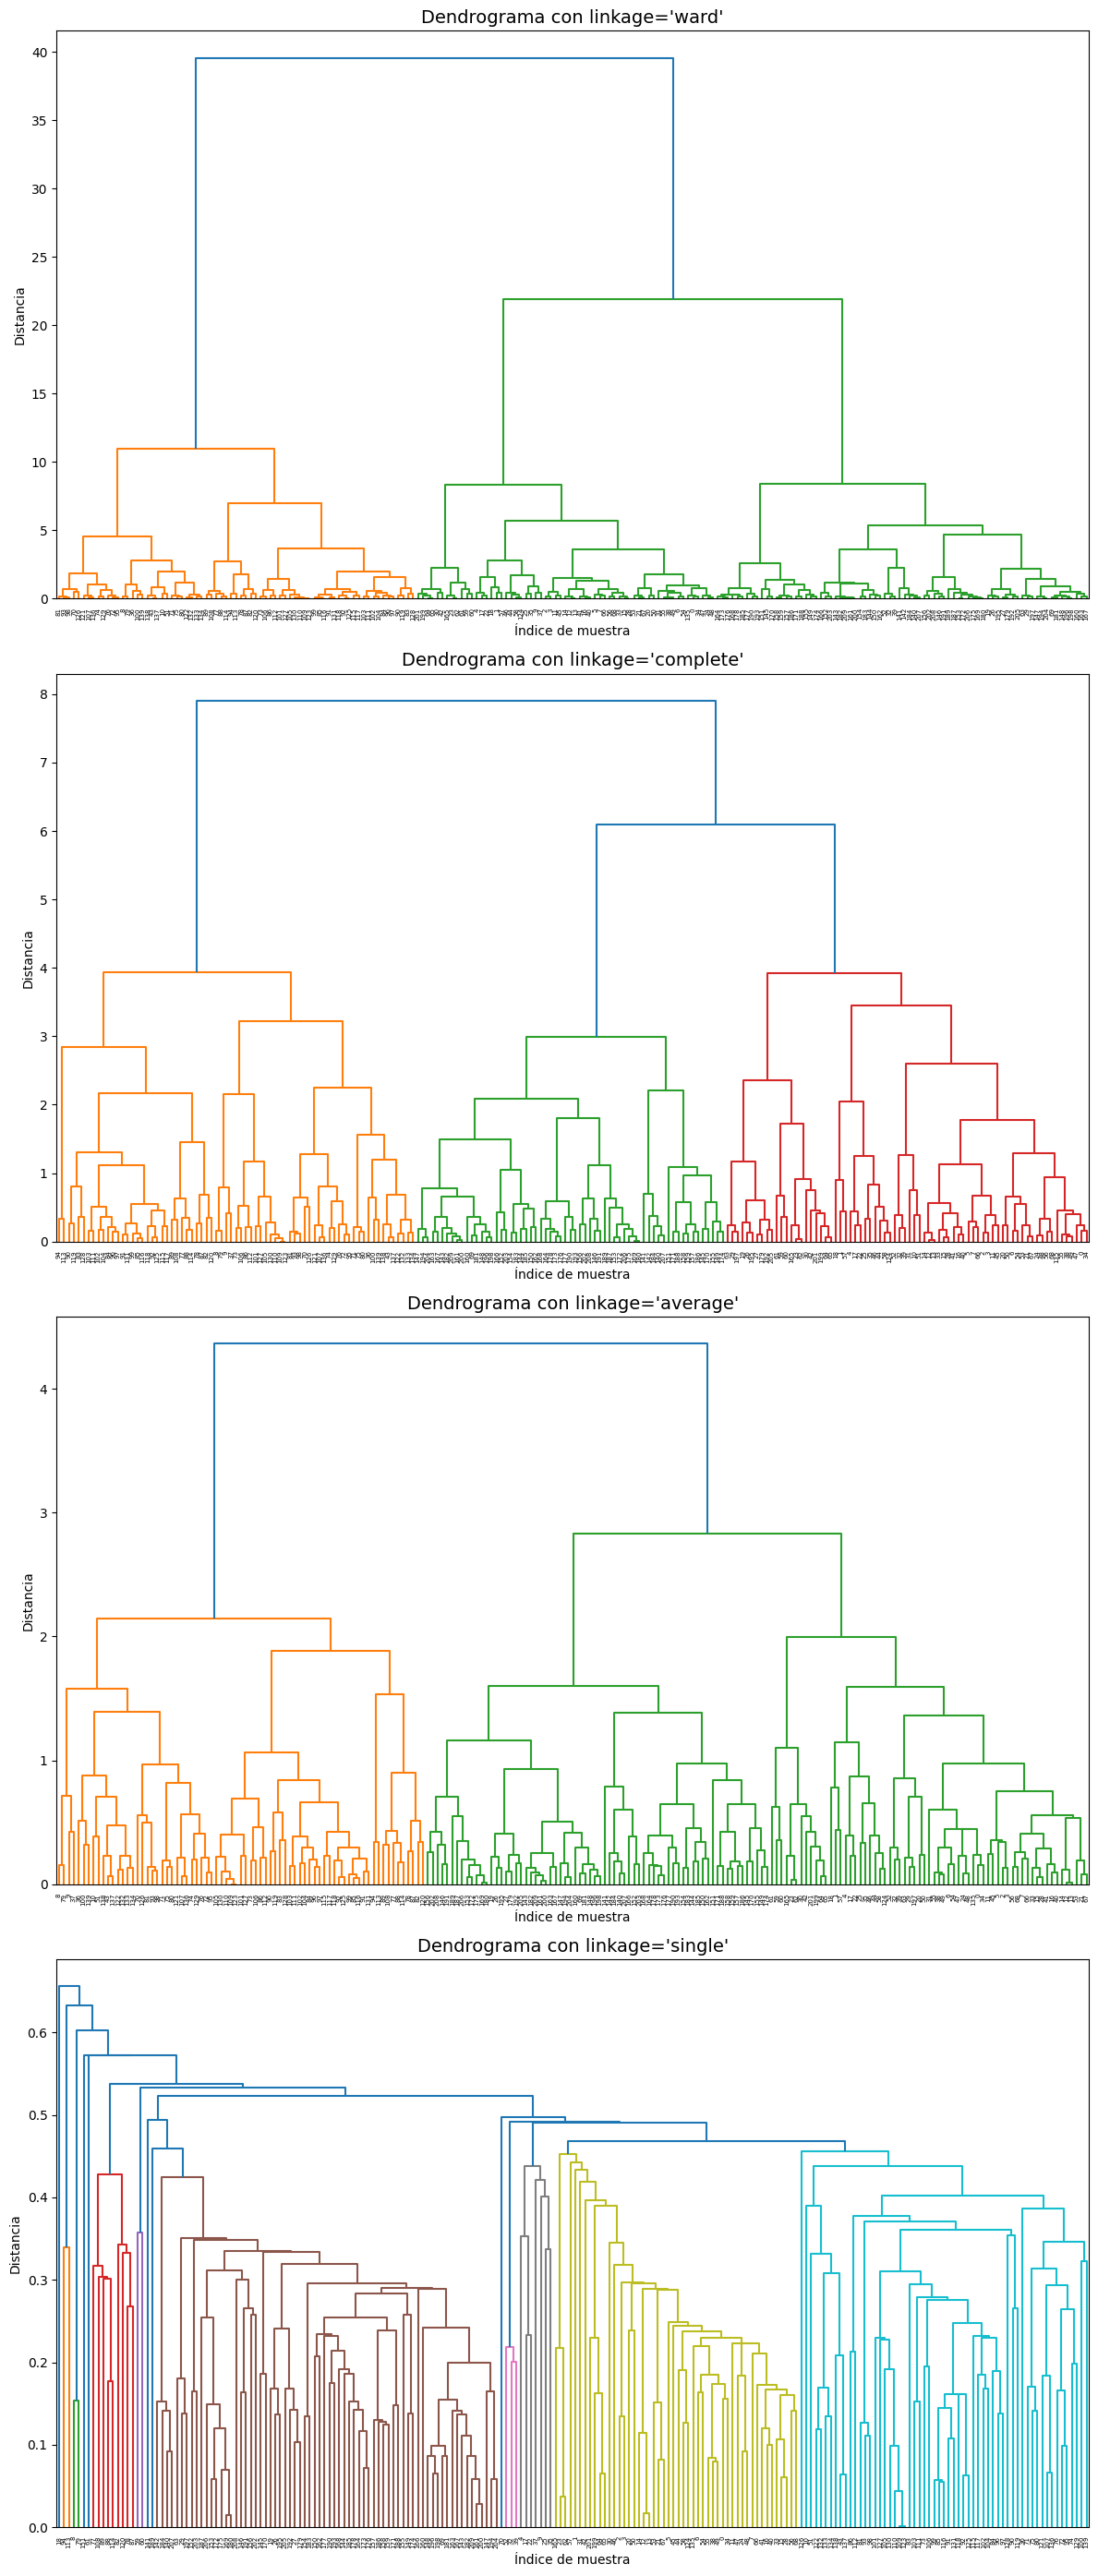

In [31]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Métodos de linkage a probar
linkage_methods = ["ward", "complete", "average", "single"]

# Dibujar un dendrograma para cada tipo de linkage
fig, axes = plt.subplots(len(linkage_methods), 1, figsize=(12, 28))

for ax, method in zip(axes, linkage_methods):
    Z = linkage(X_2d, method=method)
    dendrogram(Z, ax=ax)
    ax.set_title(f"Dendrograma con linkage='{method}'", fontsize=14)
    ax.set_xlabel("Índice de muestra")
    ax.set_ylabel("Distancia")

plt.tight_layout()
plt.show()

**ward**: muestra una separación muy clara en 3 grandes bloques, ideal para este problema. Es el más recomendado si trabajas con distancias euclídeas.

**complete** y **average**: también muestran una separación en 3 o 4 grupos razonables.

**single**: crea una estructura más encadenada (efecto cadena), lo que suele generar malos resultados en clustering — no es recomendable en este caso.

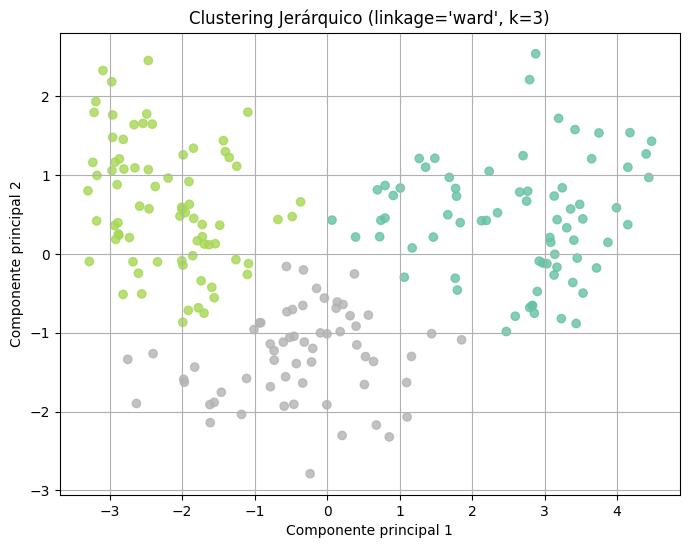

In [32]:
from sklearn.cluster import AgglomerativeClustering

# Aplicar clustering jerárquico con linkage 'ward' y 3 clusters
agglo = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels_agglo = agglo.fit_predict(X_2d)

# Visualizar los clusters jerárquicos
plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_agglo, cmap="Set2", alpha=0.8)
plt.title("Clustering Jerárquico (linkage='ward', k=3)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.grid(True)
plt.show()


Este resultado del clustering jerárquico con ward y k=3 se ve muy limpio y estructurado:

    Los tres grupos están bien separados visualmente.

    No parece haber solapamientos importantes entre los clusters.

    Es un gran punto de comparación contra KMeans.

## Método DBSCAN

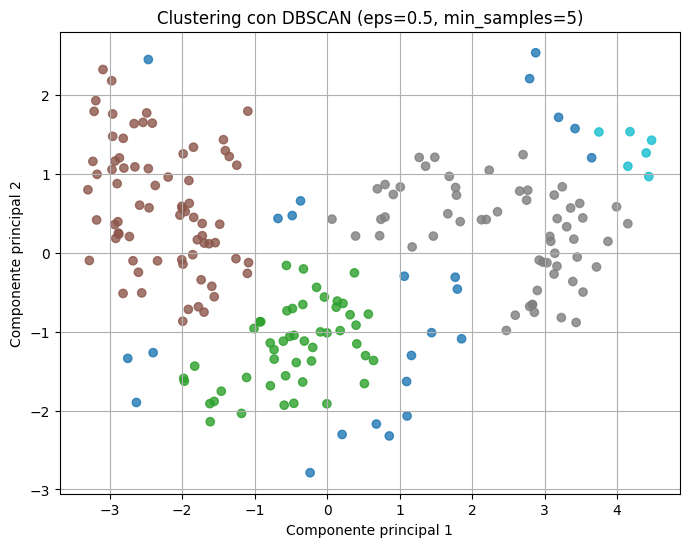

In [33]:
from sklearn.cluster import DBSCAN

# Aplicar DBSCAN con valores iniciales
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_2d)

# Visualizar el resultado de DBSCAN
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_dbscan, cmap="tab10", alpha=0.8)
plt.title("Clustering con DBSCAN (eps=0.5, min_samples=5)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.grid(True)
plt.show()


DBSCAN ha identificado más de 3 clusters, y probablemente algunos puntos como ruido (label = -1), que aparecen con un color distinto o más tenue.
Algunos grupos están razonablemente bien formados, pero otros parecen fragmentados, lo que sugiere que los valores por defecto podrían no ser ideales.

Toca ajustar los hiperparámetros:
- eps (radio de vecindad): prueba valores entre 0.3 y 0.8.

- min_samples (mínimo de vecinos para formar un núcleo): normalmente entre 3 y 10.